# MS4610 Introduction to Data Analytics || Course Project 
### Model Selection and Hyperparameter Tuning
Notebook by **Group 12**

Using cleaned data, this notebook attempts to find the model that best predicts chances of payment default. We look at model performances without any feature engineering (baseline) and the same when sufficient feature engineering has been performed. The following operations have been performed:

1. Baseline performance using gradient boosted models. 

In [12]:
# Data and image handling libraries

import numpy as np
import pandas as pd
from glob import glob
import cv2

# Classifiers

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import torch

# Data preprocessing functions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Evaluation metrics

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

# Plotting libraries

import matplotlib.pyplot as plt

# Others

from IPython.display import clear_output
from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
# Import dataset

train = pd.read_csv(".././mod_data/train.csv")
train_zero = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_zero.csv")
train_mf = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf.csv")
train_mf_res = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf_res.csv")

## Useful Functions
The functions below will be used to track the model's performance, which will assist us in hyperparameter tuning. The following functions are available:
1. **learn_progress**: Plots trends of training and cross-validation score against %age data learned

In [4]:
def learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2):
    """
    Plots learning curves for training and cross-validation for input model and dataset
    as a function of fraction of data the model has trained on.
    
    :param model: (scikit-learn model-like) The model which is being trained on the data
    :param X: (numpy array-like) Training features
    :param y: (numpy array-like) Target values for prediction
    :param res: (integer) Number of points on which progress is calculated (default = 5)
    :param scoring: (scikit-learn SCORER string) Parameter indicating learning progress.
                    Scorer options can be accessed using sklearn.metrics.SCORERS.keys()
                    (default = 'roc_auc')
    :param cv: Number of cross-validation folds (default = 2)
    
    :return:
        Renders a matplotlib pyplot object of with line plots of training and validation 
        scores.
    """
    train_sizes = np.linspace(0.1, 1, res)
    _, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes,
                                                   scoring=scoring, cv=cv)
    
    fig, ax = plt.subplots()
    plt.grid()
    
    plt.plot(train_scores.mean(axis=1), marker='o', c='blue', alpha=0.7)
    plt.plot(valid_scores.mean(axis=1), marker='o', c='red', alpha=0.7)
    
    plt.title('Learning progress')
    plt.ylabel('Score')
    plt.xlabel('Progress')
    plt.xticks([i for i in range(res)], np.linspace(0.1, 1, res))
    plt.legend(['Training score', 'Validation score'])

    plt.show()
    
    print("Training CV score: {:.4f}".format(train_scores.mean(axis=0)[1]))
    print("Validation CV score: {:.4f}".format(valid_scores.mean(axis=0)[1]))

## Baseline Model Performance
In this section, we check the performance of **gradient boosted decision-tree models** on the dataset without any feature engineering or hyperparameter tuning. This will provide a benchmark to improve upon as we modify/generate/discard features from the dataset. The models below were chosen as they can internally handle missing values. The following models have been tested.
1. XGBoost Classifier
2. LightGBM Classifier

ROC-AUC Score (no CV): 0.7138749467340612

              precision    recall  f1-score   support

           0       0.86      0.73      0.79     11829
           1       0.51      0.70      0.59      4771

    accuracy                           0.72     16600
   macro avg       0.68      0.71      0.69     16600
weighted avg       0.76      0.72      0.73     16600



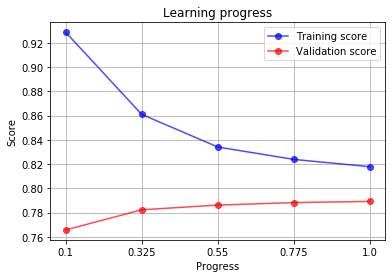

In [21]:
# XGBoost Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=4,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.7014957290059375

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     11829
           1       0.56      0.59      0.57      4771

    accuracy                           0.75     16600
   macro avg       0.70      0.70      0.70     16600
weighted avg       0.75      0.75      0.75     16600



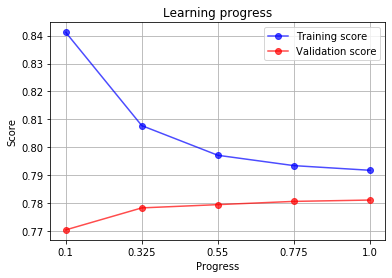

In [19]:
# LightGBM Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=200,
                       max_depth=4,
                       learning_rate=0.05, 
                       objective='binary',
                       scale_pos_weight=2.4794,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 

### On zero imputed datasets
After imputation of datasets in `DataCleaning.ipynb` we will test the models above and see if any changes in performance are observed.

ROC-AUC Score (no CV): 0.7150680148689939

              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79     11805
         1.0       0.51      0.70      0.59      4759

    accuracy                           0.72     16564
   macro avg       0.68      0.72      0.69     16564
weighted avg       0.76      0.72      0.73     16564



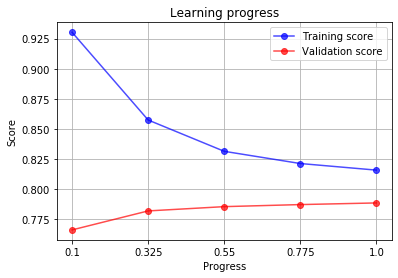

In [6]:
# XGBoost Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=4,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

### On missing forest imputed dataset
We expected somewhat better performance on missing forest imputed data.

ROC-AUC Score (no CV): 0.7111619764197022

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79     11753
         1.0       0.51      0.68      0.59      4740

    accuracy                           0.72     16493
   macro avg       0.68      0.71      0.69     16493
weighted avg       0.76      0.72      0.73     16493



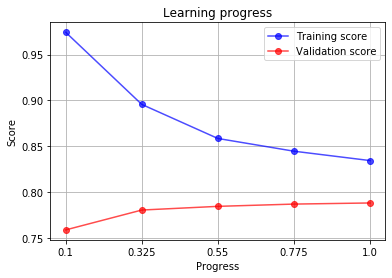

Training CV score: 0.8772
Validation CV score: 0.7817


In [11]:
# XGBoost Classifier

# Features and target are defined
y = train_mf.default_ind.values
X = train_mf.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=300,
                      max_depth=5,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.6635315303283729

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85     11753
         1.0       0.66      0.41      0.51      4740

    accuracy                           0.77     16493
   macro avg       0.73      0.66      0.68     16493
weighted avg       0.76      0.77      0.75     16493



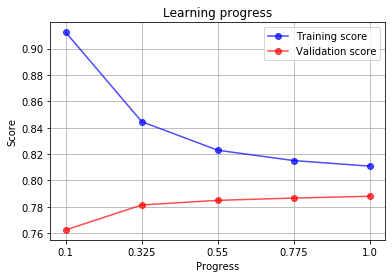

Training CV score: 0.8361
Validation CV score: 0.7833


In [10]:
# Gradient Boosting classifier

# Features and target are defined
y = train_mf.default_ind.values
X = train_mf.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = GradientBoostingClassifier(n_estimators=200)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

### On SMOTE resampled dataset

**UPDATED: 30th October, 2019**

Performance of XGBoost and LightGBM on SMOTE resampled dataset. The resampling has improved their performance significantly.

ROC-AUC Score (no CV): 0.8409807966515588

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



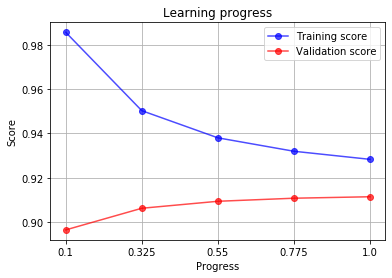

Training CV score: 0.9475
Validation CV score: 0.9054


In [23]:
# XGBoost Classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=300,
                      max_depth=5,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.8414912249803579

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



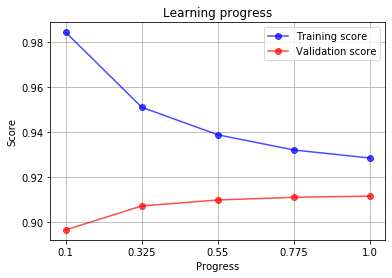

Training CV score: 0.9478
Validation CV score: 0.9058


In [24]:
# LightGBM Classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 

In [ ]:
# Gradient Boosting classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = GradientBoostingClassifier(n_estimators=300)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.8399598567479525

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



## ANN with Entity Embeddings

**UPDATED: 30th October, 2019**

Neural networks are famous for being able to generate non-linear relations between features on their own, thus mitigating the need for feature engineering. However, they can only find such relations with continuous data and are unable to deal with categorical variables. To work around this difficulty, the idea of **Entity Embeddings** was drawn from the field of Natural Language Processing (corresponding concept being **word embeddings**). Using this transformation, a categorical variable is projected into a multi-dimensional space; categorical values resulting in the same target output are clustered together. **We are using the resampled, miss forest imputed dataset here.**

Please check out the original work by Prof Yoshua Bengio et al [here](https://www.aaai.org/ocs/index.php/AAAI/AAAI11/paper/view/3659/3898) and [here](https://arxiv.org/pdf/1604.06737.pdf).

In [27]:
# Dependencies

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding

# Load data
train_mf = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf_res.csv")


# EMBEDDING FOR LOCATION ID ================================================================================

labels = train_mf.default_ind.values

le = LabelEncoder()
train_mf['location_id'] = le.fit_transform(train_mf.location_id)

vocab_size = train_mf.location_id.nunique()
max_length = 1
embed_vec_size = 36
loc_id = train_mf.location_id.values

# Define model
print('[INFO] Generating embeddings')
model = Sequential()
model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(loc_id, labels, epochs=1, batch_size=100)

# Get outputs of first layer
new_model = Sequential()
new_model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))

new_model.set_weights(model.layers[0].get_weights())
new_model.compile(optimizer='adam', loss='binary_crossentropy')

preds = new_model.predict(loc_id).reshape(-1, embed_vec_size)
embed_cols = ['loc_emb'+str(i) for i in range(preds.shape[1])]
loc_embed_df = pd.DataFrame(preds, columns=embed_cols)

# =============================================================================================================

# Scaling numerical columns of X
ss = StandardScaler()
non_num_cols = ['application_key', 'card_type', 'location_id', 'default_ind']
X_sc = ss.fit_transform(train_mf.drop(non_num_cols, axis=1).values)

X_df = pd.DataFrame(X_sc)
X_df['card_type'] = train_mf.card_type.values
X_df = pd.concat([X_df, loc_embed_df], axis=1)

y = to_categorical(train_mf.default_ind.values)
X = X_df.values

rows, cols = X.shape[0], X.shape[1]

# Defining prediction model
print('')
print('[INFO] Training model')
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=cols))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.fit(X, y, epochs=5, batch_size=100)

# Predictions
preds = []
probs = model.predict(X_val)
for i in probs:
    preds.append(np.argmax(i))

y_val_preds = []
for i in y_val:
    y_val_preds.append(np.argmax(i))

preds = np.array(preds).reshape((-1, 1))
y_val_preds = np.array(y_val_preds).reshape((-1, 1))

score = roc_auc_score(y_val_preds, preds)
print('')
print("AUC Score: {:.4f}".format(score))
print('')
print(classification_report(y_val_preds, preds))

[INFO] Generating embeddings
Epoch 1/1
117534/117534 [==============================] - 23s 192us/step - loss: 0.5856 - binary_accuracy: 0.7541

[INFO] Training model
Epoch 1/5
117534/117534 [==============================] - 3s 24us/step - loss: 0.3881 - binary_accuracy: 0.8135
Epoch 2/5
117534/117534 [==============================] - 2s 21us/step - loss: 0.3682 - binary_accuracy: 0.8230
Epoch 3/5
117534/117534 [==============================] - 3s 21us/step - loss: 0.3665 - binary_accuracy: 0.8247
Epoch 4/5
117534/117534 [==============================] - 2s 21us/step - loss: 0.3651 - binary_accuracy: 0.8250
Epoch 5/5
117534/117534 [==============================] - 3s 23us/step - loss: 0.3640 - binary_accuracy: 0.8257

AUC Score: 0.8243

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     11753
           1       0.89      0.74      0.81     11754

    accuracy                           0.82     23507
   macro avg       0.83      0